In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import warnings
import time
from tqdm import tqdm
import os
import itertools
from matplotlib.lines import Line2D
import json

# For better plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
warnings.filterwarnings('ignore')

# Check if PyTorch is available
TORCH_AVAILABLE = False
try:
    import torch
    TORCH_AVAILABLE = True
    print("PyTorch is available")
except ImportError:
    print("PyTorch is not available")

# Import the permutation weighting implementation
from permutation_weighting.estimator import PW

# Function to generate Kang-Schafer data
def generate_kang_schafer_binary(n=1000, seed=42, misspecified=False):
    """
    Generate data according to the Kang-Schafer setup with binary treatment
    
    Parameters:
    -----------
    n: int
        Number of observations
    seed: int
        Random seed
    misspecified: bool
        Whether to return the misspecified transformations of covariates
        
    Returns:
    --------
    df: pd.DataFrame
        Data frame with columns: X1-X4 (covariates), A (treatment), Y (outcome), 
        Y1 (potential outcome under treatment), Y0 (potential outcome under control),
        and X1_mis to X4_mis (misspecified covariates, if requested)
    """
    np.random.seed(seed)
    
    # Generate covariates
    X = np.random.normal(0, 1, size=(n, 4))
    
    # Treatment assignment
    ps_linear = X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]
    ps = expit(ps_linear)
    A = np.random.binomial(1, ps, size=n)
    
    # Generate potential outcomes
    Y1 = 210 + 1 + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    Y0 = 210 + 0 + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    
    # Observed outcome
    Y = A * Y1 + (1 - A) * Y0
    
    # Create DataFrame
    df = pd.DataFrame({
        'X1': X[:, 0],
        'X2': X[:, 1],
        'X3': X[:, 2],
        'X4': X[:, 3],
        'A': A,
        'Y': Y,
        'Y1': Y1,
        'Y0': Y0
    })
    
    # Add misspecified covariates if requested
    if misspecified:
        df['X1_mis'] = np.exp(X[:, 0]/2)
        df['X2_mis'] = X[:, 1] / (1 + np.exp(X[:, 0])) + 10
        df['X3_mis'] = (X[:, 0] * X[:, 2] / 25 + 0.6)**3
        df['X4_mis'] = (X[:, 1] + X[:, 3] + 20)**2
    
    return df


# Function to calculate true ATE
def true_ate(df):
    """Calculate the true average treatment effect"""
    return np.mean(df['Y1'] - df['Y0'])

# Function to estimate ATE using PW weights
def estimate_ate(df, weights):
    """Estimate ATE using PW weights"""
    # Normalize weights to sum to n
    n = len(df)
    normalized_weights = weights * n / np.sum(weights)
    
    # Weighted ATE estimate
    treated_indices = df['A'] == 1
    control_indices = df['A'] == 0
    
    weighted_treated_mean = np.sum(df.loc[treated_indices, 'Y'] * normalized_weights[treated_indices]) / np.sum(normalized_weights[treated_indices])
    weighted_control_mean = np.sum(df.loc[control_indices, 'Y'] * normalized_weights[control_indices]) / np.sum(normalized_weights[control_indices])
    
    return weighted_treated_mean - weighted_control_mean

# Function to perform cross-validation and record performance
def cross_validate_hyperparams(df, method, param_grid, method_name, n_folds=5,  use_sgd=False, use_torch=False, batch_size=False ,seed=42):
    """
    Perform cross-validation to tune hyperparameters
    
    Parameters:
    -----------
    df: pd.DataFrame
        Data frame with columns: X1-X4, A, Y, Y1, Y0
    method: str
        Classification method ('logit', 'sgd_logit', 'neural_net', etc.)
    param_grid: dict
        Dictionary mapping parameter names to lists of values to try
    method_name: str
        Name to identify this method in results
    n_folds: int
        Number of cross-validation folds
    use_sgd: bool
        Whether to use SGD-based training
    use_torch: bool
        Whether to use PyTorch-based training
    seed: int
        Random seed for reproducibility
        
    Returns:
    --------
    results: pd.DataFrame
        Data frame with results of cross-validation
    """
    # Extract features and target
    feature_cols = [col for col in df.columns if col.startswith('X') and not col.endswith('_mis')]
    X = df[feature_cols].values
    A = df['A'].values
    y = df['Y'].values
    
    # Set up cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    # True ATE
    true_ate_value = true_ate(df)
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(itertools.product(*param_grid.values()))
    
    # Results storage
    results = []
    
    # Progress tracking
    total_combos = len(param_values)
    print(f"Running {total_combos} parameter combinations for {method_name}...")
    
    # Track time
    start_time = time.time()
    
    # Loop through parameter combinations
    for i, values in enumerate(param_values):
        params = dict(zip(param_names, values))
        
        # Print progress
        if i % max(1, total_combos // 10) == 0:
            elapsed = time.time() - start_time
            print(f"Combo {i+1}/{total_combos} - Elapsed: {elapsed:.1f}s")
        
        # Store fold results
        fold_results = []
        
        # Fix parameters based on method type
        clean_params = clean_parameters_for_method(method, params, use_sgd, use_torch)
        if not clean_params:
            continue  # Skip this parameter combination if it's not valid
            
        # Run cross-validation
        for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
            # Split data
            X_train, X_test = X[train_idx], X[test_idx]
            A_train, A_test = A[train_idx], A[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            # Train PW model
            try:
                
                
                batch_size_value = None
                if batch_size and 'batch_size' in params:
                    batch_size_value = params.pop('batch_size')  # Remove from params to avoid duplicate parameter
                
                # Train PW model
                pw_result = PW(
                    A=A_train, 
                    X=X_train, 
                    classifier=method, 
                    classifier_params=params,
                    estimand='ATE',
                    num_replicates=1,  # Use 1 for speed during tuning
                    use_sgd=use_sgd,
                    use_torch=use_torch,
                    batch_size=batch_size_value if batch_size else None
                )
                
                # Save in-sample metrics
                in_sample_mse = pw_result['train'].get('MSEEvaluator', np.nan)
                in_sample_logloss = pw_result['train'].get('LogLossEvaluator', np.nan)
                
                # Apply to test set
                eval_data = {'A': A_test, 'X': X_test}
                eval_pw_result = PW(
                    A=A_train, 
                    X=X_train, 
                    classifier=method, 
                    classifier_params=clean_params,
                    estimand='ATE',
                    num_replicates=1,
                    eval_data=eval_data,
                    use_sgd=use_sgd,
                    use_torch=use_torch
                )
                
                # Get out-of-sample metrics
                out_sample_mse = eval_pw_result['eval'].get('MSEEvaluator', np.nan)
                out_sample_logloss = eval_pw_result['eval'].get('LogLossEvaluator', np.nan)
                
                # Calculate estimated ATE
                df_train = pd.DataFrame({
                    'X1': X_train[:, 0], 'X2': X_train[:, 1], 
                    'X3': X_train[:, 2], 'X4': X_train[:, 3],
                    'A': A_train, 'Y': y_train
                })
                est_ate = estimate_ate(df_train, pw_result['weights'])
                
                # Calculate absolute error in ATE
                ate_error = abs(est_ate - true_ate_value)
                
                # Save results
                fold_result = {
                    'fold': fold,
                    'in_sample_mse': in_sample_mse,
                    'in_sample_logloss': in_sample_logloss,
                    'out_sample_mse': out_sample_mse,
                    'out_sample_logloss': out_sample_logloss,
                    'ate_error': ate_error,
                    'converged': pw_result.get('convergence_info', {}).get('converged', True)
                }
                
                fold_results.append(fold_result)
            except Exception as e:
                print(f"Error with params {params} for {method_name} in fold {fold}: {str(e)}")
                continue
        
        # Skip if no valid results
        if not fold_results:
            continue
        
        # Average results across folds
        mean_results = {
            k: np.mean([r[k] for r in fold_results if k in r and not np.isnan(r[k])]) 
            for k in ['in_sample_mse', 'in_sample_logloss', 'out_sample_mse', 'out_sample_logloss', 'ate_error']
        }
        
        # Calculate standard errors
        std_results = {
            f"{k}_std": np.std([r[k] for r in fold_results if k in r and not np.isnan(r[k])]) / np.sqrt(len(fold_results))
            for k in ['in_sample_mse', 'in_sample_logloss', 'out_sample_mse', 'out_sample_logloss', 'ate_error']
        }
        
        # Save parameter combination results with method name
        # Include the original parameter values (before cleaning)
        result = {**params, **mean_results, **std_results, 'method': method_name}
        
        # Convert any lists in params to strings for safe storage
        for k, v in params.items():
            if isinstance(v, list):
                result[k] = str(v)
        
        results.append(result)
    
    return pd.DataFrame(results)

def clean_parameters_for_method(method, params, use_sgd, use_torch):
    """
    Clean and validate parameters for a specific method
    
    Parameters:
    -----------
    method : str
        The classifier method
    params : dict
        The parameter dictionary
    use_sgd : bool
        Whether using SGD
    use_torch : bool
        Whether using PyTorch
    
    Returns:
    --------
    dict or None
        Cleaned parameter dictionary or None if invalid
    """
    clean_params = params.copy()
    
    # Handle elasticnet penalty requiring l1_ratio
    if 'penalty' in clean_params and clean_params['penalty'] == 'elasticnet':
        if 'l1_ratio' not in clean_params:
            if 'solver' in clean_params and clean_params['solver'] == 'saga':
                clean_params['l1_ratio'] = 0.5  # Default value
            else:
                return None  # Invalid combination, skip
    
    # Validate solver and penalty combinations
    if 'penalty' in clean_params and clean_params['penalty'] == 'elasticnet':
        if 'solver' in clean_params and clean_params['solver'] != 'saga':
            return None  # Invalid combination, skip
    
    # Fix MLPClassifier early stopping with SGD
    if use_sgd and method == 'neural_net':
        if 'early_stopping' in clean_params:
            clean_params['early_stopping'] = False
    
    # Fix PyTorch epochs parameter (must be integer)
    if use_torch and 'epochs' in clean_params:
        clean_params['epochs'] = int(clean_params['epochs'])
    
    # Handle batch_size parameter (must be integer)
    if 'batch_size' in clean_params and clean_params['batch_size'] != 'auto':
        clean_params['batch_size'] = int(clean_params['batch_size'])
    
    # Convert hidden_layer_sizes to tuple if it's a list
    if 'hidden_layer_sizes' in clean_params and isinstance(clean_params['hidden_layer_sizes'], list):
        clean_params['hidden_layer_sizes'] = tuple(clean_params['hidden_layer_sizes'])
        
    return clean_params

def generate_model_performance_plots(results_dict, output_dir='tuning_results'):
    """
    Generate plots comparing model performance
    
    Parameters:
    -----------
    results_dict: dict
        Dictionary mapping method names to DataFrames of results
    output_dir: str
        Directory to save plots
    
    Returns:
    --------
    dict
        Dictionary of best configurations
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Combine results
    combined_results = pd.concat(results_dict.values(), ignore_index=True)
    
    # Define colors for each method
    methods = combined_results['method'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    method_colors = dict(zip(methods, colors))
    
    # Create legend elements
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', 
               markerfacecolor=method_colors[method], markersize=10, label=method)
        for method in methods
    ]
    
    # Plot 1: ATE Error vs. In-sample Log Loss
    plt.figure(figsize=(12, 8))
    
    for method in methods:
        method_data = combined_results[combined_results['method'] == method]
        plt.scatter(
            method_data['in_sample_logloss'], 
            method_data['ate_error'],
            alpha=0.7, s=60, color=method_colors[method],
            label=method
        )
    
    plt.xlabel('PW log-loss (in-sample)', fontsize=14)
    plt.ylabel('Absolute Causal Error (in-sample)', fontsize=14)
    plt.title('In-sample Causal Error vs. In-sample PW Loss', fontsize=16)
    plt.legend(handles=legend_elements, loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/in_sample_comparison.png', dpi=300)
    
    # Plot 2: ATE Error vs. Out-of-sample Log Loss
    plt.figure(figsize=(12, 8))
    
    for method in methods:
        method_data = combined_results[combined_results['method'] == method]
        plt.scatter(
            method_data['out_sample_logloss'], 
            method_data['ate_error'],
            alpha=0.7, s=60, color=method_colors[method],
            label=method
        )
    
    plt.xlabel('PW log-loss (out-of-sample)', fontsize=14)
    plt.ylabel('Absolute Causal Error (in-sample)', fontsize=14)
    plt.title('In-sample Causal Error vs. Out-of-sample PW Loss', fontsize=16)
    plt.legend(handles=legend_elements, loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/out_sample_comparison.png', dpi=300)
    
    # Find best configuration for each method
    best_configs = {}
    for method in methods:
        method_data = combined_results[combined_results['method'] == method]
        if not method_data.empty:
            best_idx = method_data['ate_error'].idxmin()
            
            best_config = {
                'ate_error': method_data.loc[best_idx, 'ate_error'],
                'in_sample_logloss': method_data.loc[best_idx, 'in_sample_logloss'],
                'out_sample_logloss': method_data.loc[best_idx, 'out_sample_logloss']
            }
            
            # Add parameters (excluding method and metrics)
            for col in method_data.columns:
                if col not in ['method', 'in_sample_mse', 'in_sample_logloss', 
                               'out_sample_mse', 'out_sample_logloss', 'ate_error',
                               'in_sample_mse_std', 'in_sample_logloss_std', 
                               'out_sample_mse_std', 'out_sample_logloss_std', 'ate_error_std']:
                    best_config[col] = method_data.loc[best_idx, col]
    
            best_configs[method] = best_config
    
    # Save best configurations to JSON
    with open(f'{output_dir}/best_configs.json', 'w') as f:
        json.dump(best_configs, f, indent=4)
    
    # Print best configurations
    print("\nBest configuration for each method:")
    for method, config in best_configs.items():
        print(f"{method}:")
        print(f"  ATE Error: {config['ate_error']:.4f}")
        print(f"  In-sample Log Loss: {config['in_sample_logloss']:.4f}")
        print(f"  Out-of-sample Log Loss: {config['out_sample_logloss']:.4f}")
        
        # Print parameters (excluding metrics)
        print("  Parameters:")
        param_keys = [k for k in config.keys() 
                     if k not in ['ate_error', 'in_sample_logloss', 'out_sample_logloss']]
        for k in param_keys:
            print(f"    {k}: {config[k]}")
        print()
    
    return best_configs


PyTorch is available


In [12]:
def final_model_evaluation(df, best_configs, output_dir='tuning_results', seed=42):
    """
    Train final models and generate ROC curves using the best configurations
    
    Parameters:
    -----------
    df: pd.DataFrame
        Data frame with columns: X1-X4, A, Y, Y1, Y0
    best_configs: dict
        Dictionary of best configurations for each method
    output_dir: str
        Directory to save plots
    seed: int
        Random seed
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract features and target
    feature_cols = [col for col in df.columns if col.startswith('X') and not col.endswith('_mis')]
    X = df[feature_cols].values
    A = df['A'].values
    
    # Set up cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    
    # Prepare method configurations
    methods_to_eval = []
    for method_name, config in best_configs.items():
        # Default values for method config
        base_method = 'logit'
        use_sgd = False
        use_torch = False
        
        # Determine the actual method type and parameters based on method name
        if method_name == 'Standard Logistic':
            base_method = 'logit'
            params = {
                'C': float(config.get('C', 1.0)),
                'penalty': str(config.get('penalty', 'l2')),
                'solver': str(config.get('solver', 'saga')),
                'max_iter': int(float(config.get('max_iter', 1000)))
            }
        elif method_name == 'Gradient Boosting':
            base_method = 'boosting'
            params = {
                'n_estimators': int(float(config.get('n_estimators', 100))),
                'learning_rate': float(config.get('learning_rate', 0.1)),
                'max_depth': int(float(config.get('max_depth', 3)))
            }
        elif method_name == 'SGD Logistic':
            base_method = 'logit'
            use_sgd = True
            params = {
                'loss': str(config.get('loss', 'log_loss')),
                'penalty': str(config.get('penalty', 'l2')),
                'alpha': float(config.get('alpha', 0.0001)),
                'learning_rate': str(config.get('learning_rate', 'optimal')),
                'eta0': float(config.get('eta0', 0.01))
            }
            if config.get('l1_ratio') is not None and config['penalty'] == 'elasticnet':
                params['l1_ratio'] = float(config['l1_ratio'])
        elif method_name == 'Neural Network':
            base_method = 'neural_net'
            use_sgd = True
            params = {
                'hidden_layer_sizes': eval(config['hidden_layer_sizes']) if isinstance(config.get('hidden_layer_sizes'), str) else config.get('hidden_layer_sizes', (100,)),
                'activation': str(config.get('activation', 'relu')),
                'alpha': float(config.get('alpha', 0.0001)),
                'learning_rate_init': float(config.get('learning_rate_init', 0.001)),
                'max_iter': int(float(config.get('max_iter', 200))),
                'early_stopping': False
            }
            if config.get('tol') is not None:
                params['tol'] = float(config['tol'])
        elif method_name == 'PyTorch Logistic':
            base_method = 'logistic'
            use_torch = True
            params = {
                'learning_rate': float(config.get('learning_rate', 0.01)),
                'l2_reg': float(config.get('l2_reg', 0.0001)),
                'epochs': int(float(config.get('epochs', 25)))
            }
        elif method_name == 'PyTorch MLP':
            base_method = 'mlp'
            use_torch = True
            params = {
                'hidden_dims': eval(config['hidden_dims']) if isinstance(config.get('hidden_dims'), str) else config.get('hidden_dims', [32]),
                'learning_rate': float(config.get('learning_rate', 0.01)),
                'l2_reg': float(config.get('l2_reg', 0.0001)),
                'epochs': int(float(config.get('epochs', 25)))
            }
        
        # Add the method to the evaluation list
        methods_to_eval.append((
            method_name,
            {'method': base_method, 'params': params, 'use_sgd': use_sgd, 'use_torch': use_torch}
        ))
    
    # Results for ROC curves
    roc_results = {method_name: {'tpr': [], 'fpr': [], 'auc': []} for method_name, _ in methods_to_eval}
    
    # Define colors for ROC curves
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods_to_eval)))
    method_colors = dict(zip([name for name, _ in methods_to_eval], colors))
    
    # Evaluate each method
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        A_train, A_test = A[train_idx], A[test_idx]
        
        # Random seed for this fold
        fold_seed = seed + fold
        np.random.seed(fold_seed)
        
        # Create permuted test data
        test_size = len(X_test)
        perm_idx = np.random.permutation(test_size)
        A_perm = A_test[perm_idx]  # Permuted treatments
        
        for method_name, config in methods_to_eval:
            try:
                # Train model
                print(f"Training {method_name} on fold {fold}...")
                pw_result = PW(
                    A=A_train, 
                    X=X_train, 
                    classifier=config['method'], 
                    classifier_params=config['params'],
                    estimand='ATE',
                    num_replicates=1,
                    use_sgd=config['use_sgd'],
                    use_torch=config['use_torch']
                )
                
                # Apply to both original and permuted test data
                weights_orig = pw_result['weights_function'](A_test, X_test) if callable(pw_result.get('weights_function')) else None
                weights_perm = pw_result['weights_function'](A_perm, X_test) if callable(pw_result.get('weights_function')) else None
                
                # If we don't have a weights function, train a model directly on the test data
                if weights_orig is None or weights_perm is None:
                    # Create a new pair of test sets with observed and permuted data
                    X_observed = X_test
                    A_observed = A_test
                    X_permuted = X_test
                    A_permuted = A_perm
                    
                    # Train a small model using the same config on this test data
                    mini_pw = PW(
                        A=np.concatenate([A_observed, A_permuted]),
                        X=np.vstack([X_observed, X_permuted]),
                        classifier=config['method'],
                        classifier_params=config['params'],
                        estimand='ATE',
                        num_replicates=1,
                        use_sgd=config['use_sgd'],
                        use_torch=config['use_torch']
                    )
                    
                    # Extract weights - first half is observed, second half is permuted
                    if len(mini_pw['weights']) == 2 * test_size:
                        weights_orig = mini_pw['weights'][:test_size]
                        weights_perm = mini_pw['weights'][test_size:]
                    else:
                        # Something went wrong with the weights - skip this method
                        continue
                
                # Convert weights to probabilities for the ROC curve
                # For observed data (C=0), probability should be low
                # For permuted data (C=1), probability should be high
                probs_orig = weights_orig / (1 + weights_orig)
                probs_perm = weights_perm / (1 + weights_perm)
                
                # Combine data and create labels: 1 for permuted, 0 for observed
                y_score = np.concatenate([probs_perm, probs_orig])
                y_true = np.concatenate([np.ones(test_size), np.zeros(test_size)])
                
                # Calculate ROC curve
                fpr, tpr, _ = roc_curve(y_true, y_score)
                roc_auc = auc(fpr, tpr)
                
                # Store results
                roc_results[method_name]['fpr'].append(fpr)
                roc_results[method_name]['tpr'].append(tpr)
                roc_results[method_name]['auc'].append(roc_auc)
                
            except Exception as e:
                print(f"Error with {method_name} in fold {fold}: {str(e)}")
                continue
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    for method_name, result in roc_results.items():
        if not result['auc']:
            print(f"No valid results for {method_name}")
            continue
            
        # Calculate mean AUC
        mean_auc = np.mean(result['auc'])
        
        # Interpolate to get average ROC curve
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        
        for i in range(len(result['fpr'])):
            interp_tpr = np.interp(mean_fpr, result['fpr'][i], result['tpr'][i])
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        
        # Plot average ROC curve
        color = method_colors.get(method_name, 'b')
        plt.plot(
            mean_fpr, mean_tpr,
            label=f'{method_name} (AUC = {mean_auc:.3f})',
            lw=2, alpha=0.8, color=color
        )
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    
    # Configure plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curves for Different Models', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True)
    
    # Save plot
    plt.tight_layout()
    plt.savefig(f'{output_dir}/roc_curves.png', dpi=300)
    plt.close()

In [13]:
def main():
    """
    Main function to run hyperparameter tuning and evaluate models
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Create directory for results
    os.makedirs('tuning_results', exist_ok=True)
    
    # Generate Kang-Schafer data
    print("Generating Kang-Schafer data...")
    df = generate_kang_schafer_binary(n=2000, seed=42, misspecified=False)
    print(f"Generated data with {len(df)} observations")
    print(f"True ATE: {true_ate(df):.4f}")
    
    # Set up hyperparameter grids for different models
    
    # 1. Standard Logistic Regression
    standard_logit_params = {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['l1', 'l2'],  # Removed elasticnet to avoid errors
        'solver': ['saga', 'liblinear'],
        'max_iter': [1000]
    }
    
    # 2. Gradient Boosting
    boosting_params = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [2, 3, 4, 5, 6]
    }
    
    # 3. SGD Logistic Regression
    sgd_logit_params = {
        'loss': ['log_loss'],
        'penalty': ['l1', 'l2'],
        'alpha': [0.000001, 0.0001],
        'learning_rate': ['constant', 'adaptive'],
        'eta0': [0.0001, 0.01],
        'max_iter': [500],
    }
    
    # 4. Neural Network - fixed early_stopping issue
    neural_net_params = {
        'hidden_layer_sizes': [(32,), (64,)],
        'activation': ['relu', 'tanh'],
        'alpha': [ 0.0001, 0.001],
        'learning_rate_init': [ 0.001, 0.01],
        'max_iter': [500],
        'early_stopping': [False],
        'tol': [1e-4]
    }
    
    # 5. PyTorch models (if available)
    torch_logistic_params = {
        'learning_rate': [0.001, 0.01],
        'l2_reg': [0.00001, 0.0001],
        'epochs': [25]  # Reduced to decrease training time
    }

    torch_mlp_params = {
        'hidden_dims': [ [32], [64]],  # Simplified architecture
        'learning_rate': [0.001, 0.01],
        'l2_reg': [0.00001, 0.0001],
        'epochs': [25]  # Reduced to decrease training time
    }
    
    # 6. Batch-then-permute SGD parameters
    batch_sgd_params = {
        'loss': ['log_loss'],
        'penalty': ['l1', 'l2'],
        'alpha': [0.000001, 0.0001],
        'learning_rate': ['constant', 'adaptive'],
        'eta0': [0.0001, 0.01],
        'max_iter': [500],
        'batch_size': [32, 64]  # Added batch sizes for batch-then-permute
    }
    
    # 7. Batch-then-permute Neural Network parameters
    batch_nn_params = {
        'hidden_layer_sizes': [(32,), (64,)],  # Reduced options to save computation time
        'activation': ['relu'],
        'alpha': [0.00001, 0.001],
        'learning_rate_init': [0.001],
        'max_iter': [500],
        'early_stopping': [False],
        'batch_size': [32, 64]  # Added batch sizes for batch-then-permute
    }
    
    # 8. Batch-then-permute PyTorch parameters
    batch_torch_params = {
        'learning_rate': [0.001, 0.01],
        'l2_reg': [0.0001, 0.001],
        'epochs': [25],
        'batch_size': [32, 64]  # Added batch sizes for batch-then-permute
    }

    # Run hyperparameter tuning
    all_results = {}
    
    # 1. Standard Logistic Regression
    print("\nTuning Standard Logistic Regression...")
    std_logit_results = cross_validate_hyperparams(
        df, 'logit', standard_logit_params, 
        method_name='Standard Logistic',
        n_folds=5, seed=42
    )
    all_results['Standard Logistic'] = std_logit_results
    
    # 2. Gradient Boosting
    print("\nTuning Gradient Boosting...")
    boosting_results = cross_validate_hyperparams(
        df, 'boosting', boosting_params, 
        method_name='Gradient Boosting',
        n_folds=5, seed=42
    )
    all_results['Gradient Boosting'] = boosting_results
    
    # 3. SGD Logistic Regression
    print("\nTuning SGD Logistic Regression...")
    sgd_results = cross_validate_hyperparams(
        df, 'logit', sgd_logit_params, 
        method_name='SGD Logistic',
        n_folds=5, use_sgd=True, seed=42
    )
    all_results['SGD Logistic'] = sgd_results
    
    # 4. Neural Network with SGD
    print("\nTuning Neural Network...")
    nn_results = cross_validate_hyperparams(
        df, 'neural_net', neural_net_params, 
        method_name='Neural Network',
        n_folds=5, use_sgd=True, seed=42
    )
    all_results['Neural Network'] = nn_results
    
    # 5. Batch-then-permute SGD Logistic
    print("\nTuning Batch-then-permute SGD Logistic...")
    batch_sgd_results = cross_validate_hyperparams(
        df, 'logit', batch_sgd_params, 
        method_name='Batch-SGD Logistic',
        n_folds=3, use_sgd=True, batch_size=True, seed=42
    )
    all_results['Batch-SGD Logistic'] = batch_sgd_results
    
    # 6. Batch-then-permute Neural Network
    print("\nTuning Batch-then-permute Neural Network...")
    batch_nn_results = cross_validate_hyperparams(
        df, 'neural_net', batch_nn_params, 
        method_name='Batch-Neural Network',
        n_folds=3, use_sgd=True, batch_size=True, seed=42
    )
    all_results['Batch-Neural Network'] = batch_nn_results
    
    # PyTorch models (if available)
    if TORCH_AVAILABLE:
        # 7. PyTorch Logistic Regression
        print("\nTuning PyTorch Logistic Regression...")
        torch_logistic_results = cross_validate_hyperparams(
            df, 'logistic', torch_logistic_params, 
            method_name='PyTorch Logistic',
            n_folds=3, use_torch=True, seed=42  # Reduced folds to save time
        )
        all_results['PyTorch Logistic'] = torch_logistic_results
        
        # 8. PyTorch MLP
        print("\nTuning PyTorch MLP...")
        torch_mlp_results = cross_validate_hyperparams(
            df, 'mlp', torch_mlp_params, 
            method_name='PyTorch MLP',
            n_folds=3, use_torch=True, seed=42  # Reduced folds to save time
        )
        all_results['PyTorch MLP'] = torch_mlp_results
        
        # 9. Batch-then-permute PyTorch Logistic
        print("\nTuning Batch-then-permute PyTorch Logistic...")
        batch_torch_logistic_results = cross_validate_hyperparams(
            df, 'logistic', batch_torch_params, 
            method_name='Batch-PyTorch Logistic',
            n_folds=3, use_torch=True, batch_size=True, seed=42
        )
        all_results['Batch-PyTorch Logistic'] = batch_torch_logistic_results
        
        # 10. Batch-then-permute PyTorch MLP
        print("\nTuning Batch-then-permute PyTorch MLP...")
        batch_torch_mlp_results = cross_validate_hyperparams(
            df, 'mlp', batch_torch_params, 
            method_name='Batch-PyTorch MLP',
            n_folds=3, use_torch=True, batch_size=True, seed=42
        )
        all_results['Batch-PyTorch MLP'] = batch_torch_mlp_results
    
    # Generate combined performance plots and get best configurations
    best_configs = generate_model_performance_plots(all_results)
    
    # Final model evaluation with ROC curves
    print("\nGenerating ROC curves...")
    final_model_evaluation(df, best_configs)
    
    print("\nHyperparameter tuning complete. Results saved to 'tuning_results' directory.")

Generating Kang-Schafer data...
Generated data with 2000 observations
True ATE: 0.9484

Tuning Standard Logistic Regression...
Running 12 parameter combinations for Standard Logistic...
Combo 1/12 - Elapsed: 0.0s
Combo 2/12 - Elapsed: 0.2s
Combo 3/12 - Elapsed: 0.4s
Combo 4/12 - Elapsed: 0.6s
Combo 5/12 - Elapsed: 0.9s
Combo 6/12 - Elapsed: 1.2s
Combo 7/12 - Elapsed: 1.3s
Combo 8/12 - Elapsed: 1.5s
Combo 9/12 - Elapsed: 1.7s
Combo 10/12 - Elapsed: 2.0s
Combo 11/12 - Elapsed: 2.3s
Combo 12/12 - Elapsed: 2.6s

Tuning Gradient Boosting...
Running 20 parameter combinations for Gradient Boosting...
Combo 1/20 - Elapsed: 0.0s
Combo 3/20 - Elapsed: 4.6s
Combo 5/20 - Elapsed: 12.4s
Combo 7/20 - Elapsed: 19.3s
Combo 9/20 - Elapsed: 25.4s
Combo 11/20 - Elapsed: 34.7s
Combo 13/20 - Elapsed: 43.6s
Combo 15/20 - Elapsed: 58.9s
Combo 17/20 - Elapsed: 72.6s
Combo 19/20 - Elapsed: 84.6s

Tuning SGD Logistic Regression...
Running 16 parameter combinations for SGD Logistic...
Combo 1/16 - Elapsed: 0.0s


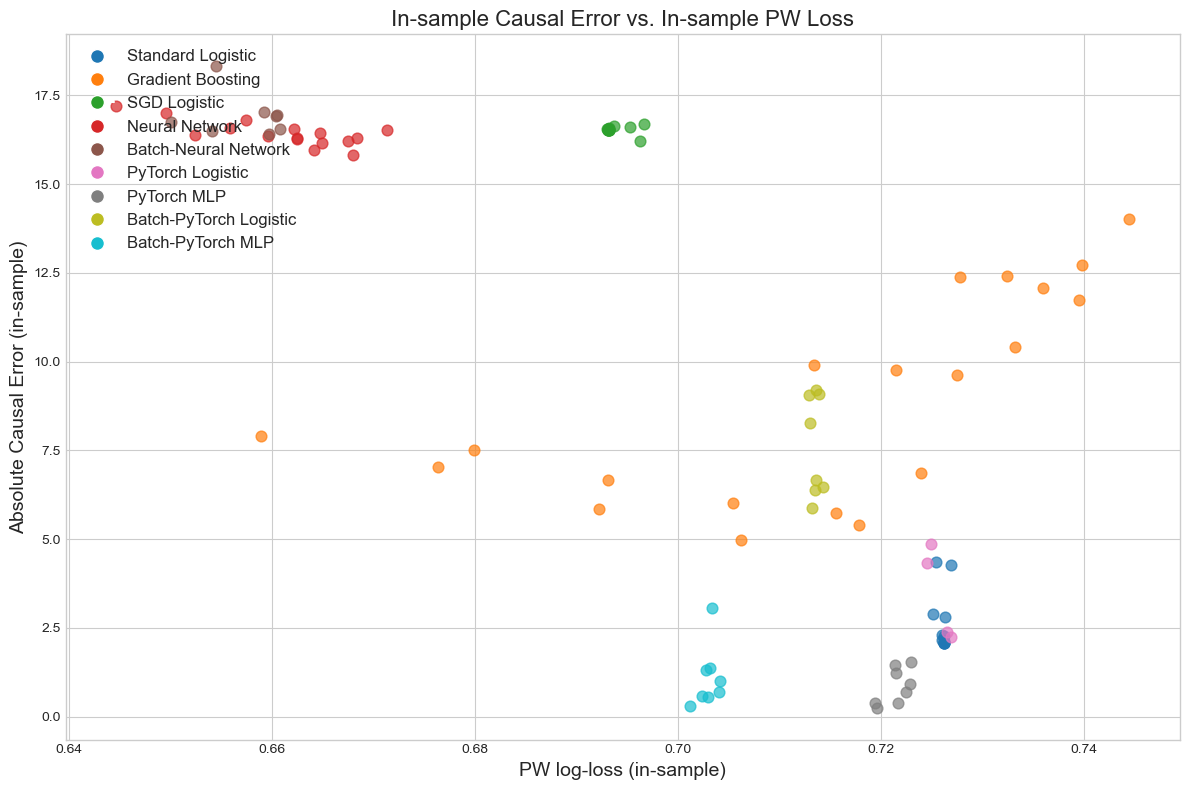

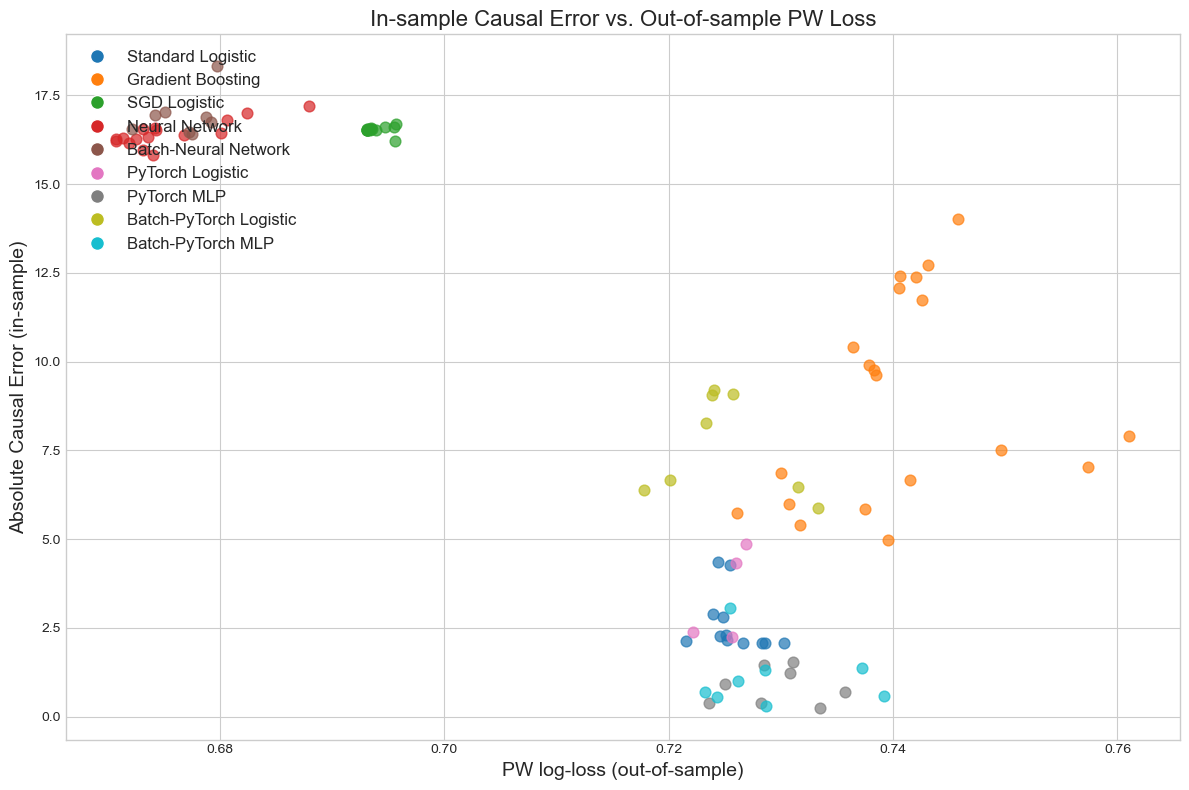

In [14]:
if __name__ == "__main__":
    main()